<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## **MSDS453 - Research Assignment 02 - Classification and Clustering**

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [3]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [4]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [6]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
  text = document.text
  text = remove_punctuation(text)
  text = lower_case(text)
  text = remove_tags(text)
  text = remove_special_chars_and_digits(text)


  return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
     tokens = nltk.word_tokenize(document.text)
     return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
     return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
      output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
      result.append(TokenizedDocument(document.doc_id, output_tokens))
      return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
     result = []
     stemmer = PorterStemmer()
     for document in documents:
         output_tokens = [stemmer.stem(w) for w in document.tokens]
         result.append(TokenizedDocument(document.doc_id, output_tokens))

     return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []

    stop_words = set(nltk.corpus.stopwords.words('english'))
    for document in documents:
         filtered_tokens = [w for w in document.tokens if not w in stop_words]
         result.append(TokenizedDocument(document.doc_id, filtered_tokens))

    return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.

    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the
    #tokenized text and matrix size

    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not

In [8]:
## Experimental#1 code here will show you the movie titles for the topics
## Uncomment all the code in this cell and it will override the above functions
## Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
## or you can ignore the commented lines for Experiment#1 code and continue your assignment.

# def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):
#
#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
#                                           eta='auto',iterations=100,random_state=23,passes=20)
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
#
#     # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[ldamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return ldamodel,dictionary,index,doc_term_matrix

###########
"""  THIS BROKE MY CODE
def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):

     dictionary = corpora.Dictionary(doc_clean)
     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
     # generate LSA model
     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)

     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])
"""
#     # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[lsamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return lsamodel, dictionary, index
#
############
##
## When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
##
## model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
##
## Similarly for LSA...

'  THIS BROKE MY CODE\ndef create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):\n\n     dictionary = corpora.Dictionary(doc_clean)\n     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]\n     # generate LSA model\n     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)\n\n     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))\n     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])\n'

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest**

In [9]:
def k_means(titles, tfidf_matrix, k=3):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    # How to see the results of the k-means clustering
    print ("cluster_title", cluster_title)
    print ("clusters", clusters)
    print ("frame", frame)
    return cluster_title,clusters,frame

def classifiers(x, y, model_type, cv = 3):

    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial

    #can define cv value for cross validation.

    #function returns the train test split scores of each model.

    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()

    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    return accy

## Visualization Utility Functions

In [10]:
def plot_lsa(number_of_topics, words):

    # BARRYC experimental#1
    #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color,
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [11]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
data = get_corpus_df(CORPUS_PATH)

In [12]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [13]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]
data = get_corpus_df(CORPUS_PATH)

In [14]:
corpus_df.shape

(200, 9)

In [15]:
corpus_df.head(90)

DSI_Title  \
Doc_ID                              
90      LKP_Doc1_Angel_has_fallen   
91      LKP_Doc2_Angel_has_fallen   
92      LKP_Doc3_Angel_has_fallen   
93      LKP_Doc4_Angel_has_fallen   
94      LKP_Doc5_Angel_has_fallen   
...                           ...   
40              MDO_Doc1_LostCity   
41              MDO_Doc2_LostCity   
42              MDO_Doc3_LostCity   
43              MDO_Doc4_LostCity   
44              MDO_Doc5_LostCity   

                                                     Text  \
Doc_ID                                                      
90      Target is on the move . '' Heavily outnumbered...   
91      The sleepy , dopey action bonanza `` Angel Has...   
92      `` Angel Has Fallen '' marks the third time th...   
93      Improving through blandness . So Mike Banning ...   
94      This review may contain spoilers . Angel Has F...   
...                                                   ...   
40      The Lost City isnt an especially unique film ;...   
41      Loretta Sage ( Sandra Bullock ) is an academic...   
42      The Lost City scratches that particular Channi...   
43      The Lost City is every bit the romantic advent...   
44      As superhero films strengthened their grip on ...   

             Submission File Name Student Name Genre of Movie  \
Doc_ID                                                          
90      LKP_Doc1_Angel_has_fallen          LKP         Action   
91      LKP_Doc2_Angel_has_fallen          LKP         Action   
92      LKP_Doc3_Angel_has_fallen          LKP         Action   
93      LKP_Doc4_Angel_has_fallen          LKP         Action   
94      LKP_Doc5_Angel_has_fallen          LKP         Action   
...                           ...          ...            ...   
40              MDO_Doc1_LostCity          MDO         Comedy   
41              MDO_Doc2_LostCity          MDO         Comedy   
42              MDO_Doc3_LostCity          MDO         Comedy   
43              MDO_Doc4_LostCity          MDO         Comedy   
44              MDO_Doc5_LostCity          MDO         Comedy   

       Review Type (pos or neg)       Movie Title  \
Doc_ID                                              
90                     Negative  Angel_has_fallen   
91                     Negative  Angel_has_fallen   
92                     Negative  Angel_has_fallen   
93                     Negative  Angel_has_fallen   
94                     Negative  Angel_has_fallen   
...                         ...               ...   
40                     Positive         Lost City   
41                     Positive         Lost City   
42                     Positive         Lost City   
43                     Positive         Lost City   
44                     Positive         Lost City   

                          Descriptor  Doc_ID  
Doc_ID                                        
90      Action_Angel_has_fallen_N_90      90  
91      Action_Angel_has_fallen_N_91      91  
92      Action_Angel_has_fallen_N_92      92  
93      Action_Angel_has_fallen_N_93      93  
94      Action_Angel_has_fallen_N_94      94  
...                              ...     ...  
40             Comedy_Lost City_P_40      40  
41             Comedy_Lost City_P_41      41  
42             Comedy_Lost City_P_42      42  
43             Comedy_Lost City_P_43      43  
44             Comedy_Lost City_P_44      44  

[90 rows x 9 columns]

In [16]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [17]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 concepts and 10 words

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"')]


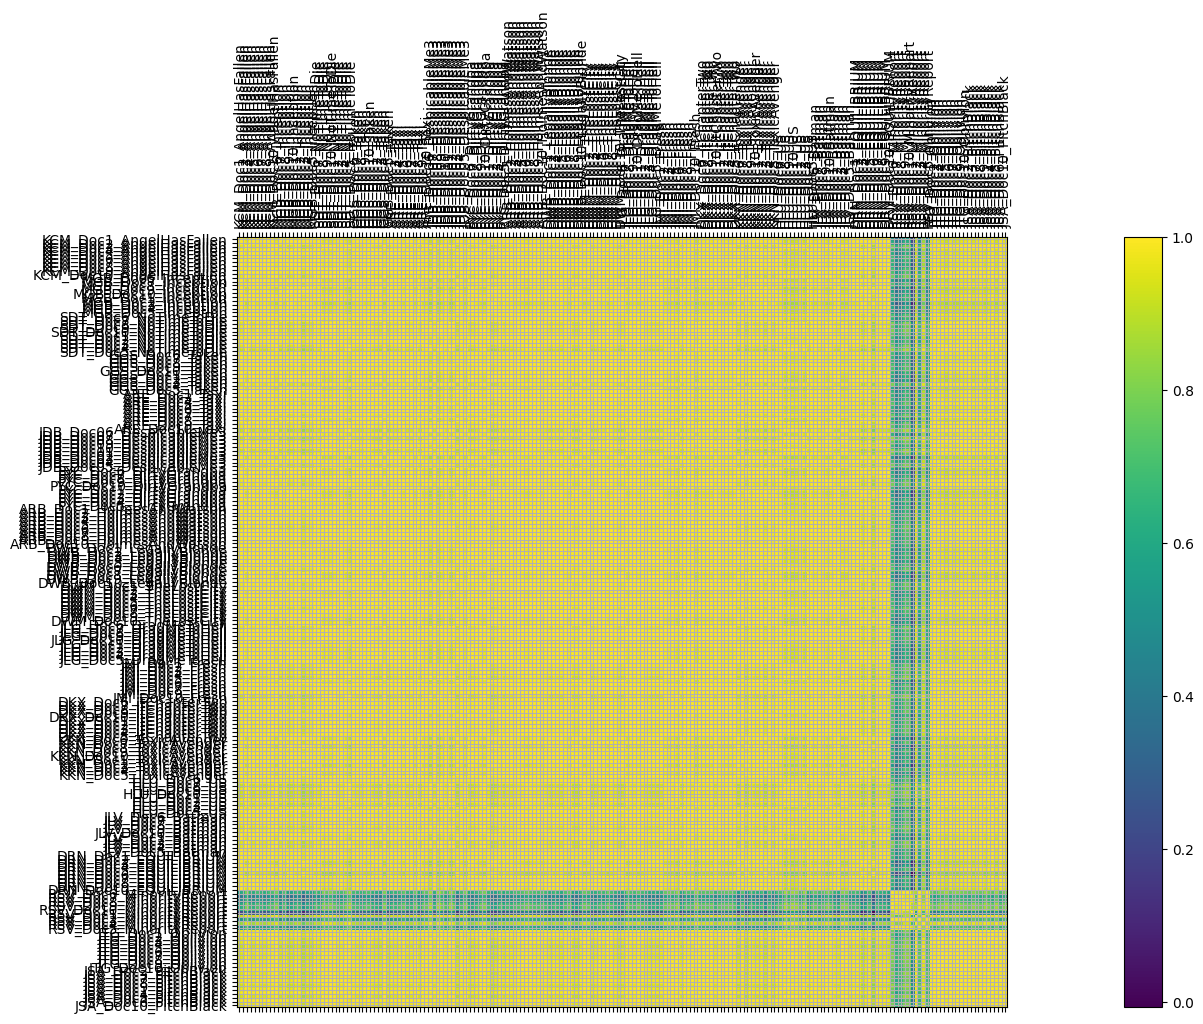

In [18]:
model_2concepts_10words = plot_lsa(2, 10)

### Plotting 6 concepts and 10 words

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"'), (2, '0.366*"equilibrium" + 0.232*"matrix" + 0.189*"preston" + 0.128*"anderton" + 0.127*"christian" + -0.125*"horror" + -0.116*"batman" + 0.115*"cleric" + -0.094*"makes" + 0.094*"scene"'), (3, '-0.469*"movie" + 0.276*"preston" + 0.207*"batman" + 0.154*"equilibrium" + 0.148*"world" + 0.147*"action" + -0.128*"toxic" + 0.127*"emotions" + -0.114*"movies" + 0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" + -0.199*"acti

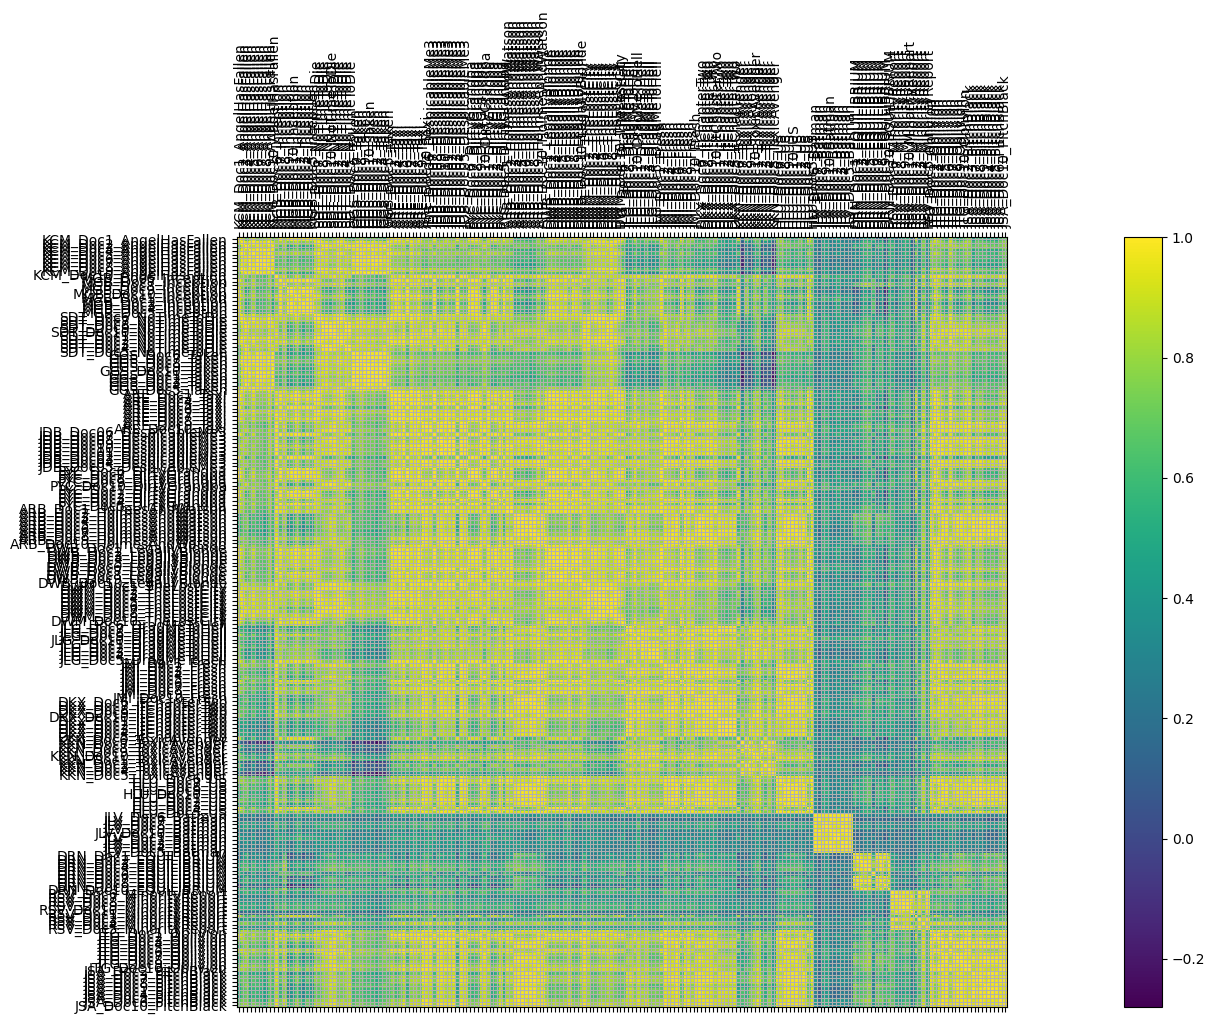

In [19]:
model_6concepts_10words=plot_lsa(6, 10)

### Plotting 20 concepts and 10 words

[(0, '-0.427*"movie" + -0.187*"would" + -0.173*"action" + -0.143*"equilibrium" + -0.143*"first" + -0.142*"movies" + -0.123*"scene" + -0.111*"people" + -0.110*"scenes" + -0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"'), (2, '0.366*"equilibrium" + 0.232*"matrix" + 0.189*"preston" + 0.128*"anderton" + 0.127*"christian" + -0.125*"horror" + -0.116*"batman" + 0.115*"cleric" + -0.094*"makes" + 0.094*"scene"'), (3, '-0.469*"movie" + 0.276*"preston" + 0.207*"batman" + 0.154*"equilibrium" + 0.148*"world" + 0.147*"action" + -0.128*"toxic" + 0.127*"emotions" + -0.114*"movies" + 0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '-0.366*"toxic" + -0.225*"horror" + -0.217*"avenger" +

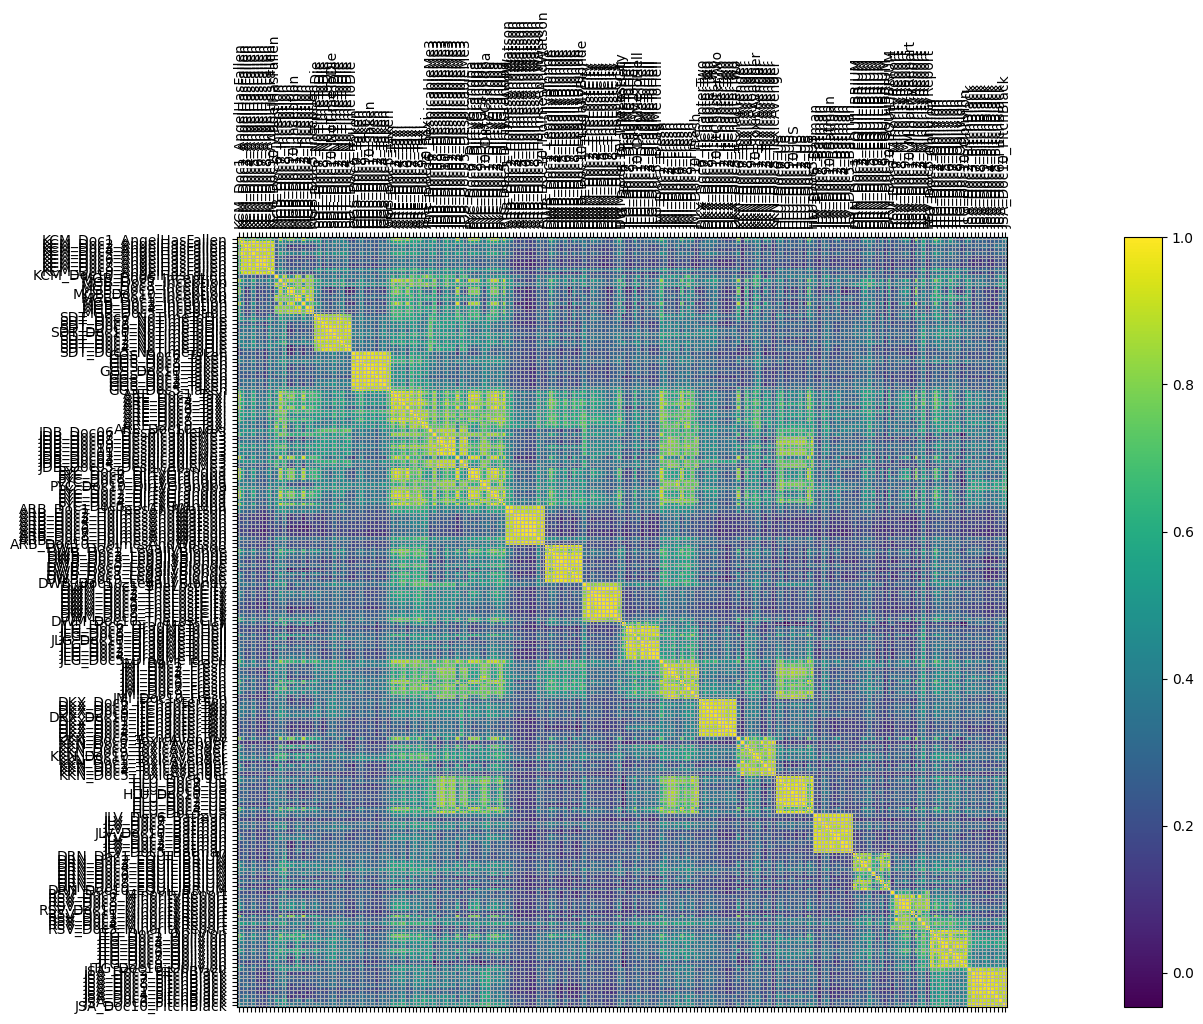

In [20]:
model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence

In [21]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


coherence ={'6 concepts 10 words':coherence_values[0],
           '2 concepts 10 words': coherence_values[1],
           '20 concepts 10 words':coherence_values[2]}

print(coherence)

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"'), (2, '0.366*"equilibrium" + 0.232*"matrix" + 0.189*"preston" + 0.128*"anderton" + 0.127*"christian" + -0.125*"horror" + -0.116*"batman" + 0.115*"cleric" + -0.094*"makes" + 0.094*"scene"'), (3, '0.469*"movie" + -0.276*"preston" + -0.207*"batman" + -0.154*"equilibrium" + -0.148*"world" + -0.147*"action" + 0.128*"toxic" + -0.127*"emotions" + 0.114*"movies" + -0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" + -0.199*"

[(0, '0.427*"movie" + 0.187*"would" + 0.173*"action" + 0.143*"equilibrium" + 0.143*"first" + 0.142*"movies" + 0.123*"scene" + 0.111*"people" + 0.110*"scenes" + 0.109*"story"'), (1, '-0.435*"anderton" + -0.285*"minority" + -0.261*"report" + -0.211*"precrime" + -0.209*"spielberg" + 0.199*"movie" + -0.174*"technology" + -0.154*"future" + 0.131*"equilibrium" + 0.096*"matrix"')]


[(0, '-0.427*"movie" + -0.187*"would" + -0.173*"action" + -0.143*"equilibrium" + -0.143*"first" + -0.142*"movies" + -0.123*"scene" + -0.111*"people" + -0.110*"scenes" + -0.109*"story"'), (1, '0.435*"anderton" + 0.285*"minority" + 0.261*"report" + 0.211*"precrime" + 0.209*"spielberg" + -0.199*"movie" + 0.174*"technology" + 0.154*"future" + -0.131*"equilibrium" + -0.096*"matrix"'), (2, '-0.366*"equilibrium" + -0.232*"matrix" + -0.189*"preston" + -0.128*"anderton" + -0.127*"christian" + 0.125*"horror" + 0.116*"batman" + -0.115*"cleric" + 0.094*"makes" + -0.094*"scene"'), (3, '0.469*"movie" + -0.276*"preston" + -0.207*"batman" + -0.154*"equilibrium" + -0.148*"world" + -0.147*"action" + 0.128*"toxic" + -0.127*"emotions" + 0.114*"movies" + -0.112*"sense"'), (4, '-0.537*"batman" + -0.292*"joker" + -0.209*"bruce" + -0.175*"keaton" + -0.171*"gotham" + -0.170*"wayne" + -0.141*"nicholson" + -0.128*"movie" + -0.124*"burton" + -0.123*"vicki"'), (5, '0.366*"toxic" + 0.225*"horror" + 0.217*"avenger" 

## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [22]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

[(0, '0.005*"movie" + 0.003*"black" + 0.003*"planet" + 0.002*"pitch" + 0.002*"never" + 0.002*"anderton" + 0.002*"story" + 0.002*"scene" + 0.002*"would" + 0.002*"character" + 0.002*"first" + 0.002*"scenes" + 0.002*"little" + 0.002*"things" + 0.002*"characters" + 0.002*"though" + 0.002*"riddick" + 0.002*"alien" + 0.002*"three" + 0.002*"could"'), (1, '0.006*"movie" + 0.004*"action" + 0.003*"story" + 0.003*"world" + 0.003*"would" + 0.003*"people" + 0.003*"first" + 0.002*"still" + 0.002*"makes" + 0.002*"films" + 0.002*"little" + 0.002*"movies" + 0.002*"loretta" + 0.002*"years" + 0.002*"could" + 0.002*"something" + 0.002*"characters" + 0.002*"really" + 0.002*"though" + 0.002*"character"'), (2, '0.011*"movie" + 0.004*"action" + 0.003*"would" + 0.003*"never" + 0.003*"first" + 0.003*"character" + 0.003*"films" + 0.003*"movies" + 0.002*"bryan" + 0.002*"world" + 0.002*"toxic" + 0.002*"people" + 0.002*"taken" + 0.002*"characters" + 0.002*"could" + 0.002*"something" + 0.002*"story" + 0.002*"almost"

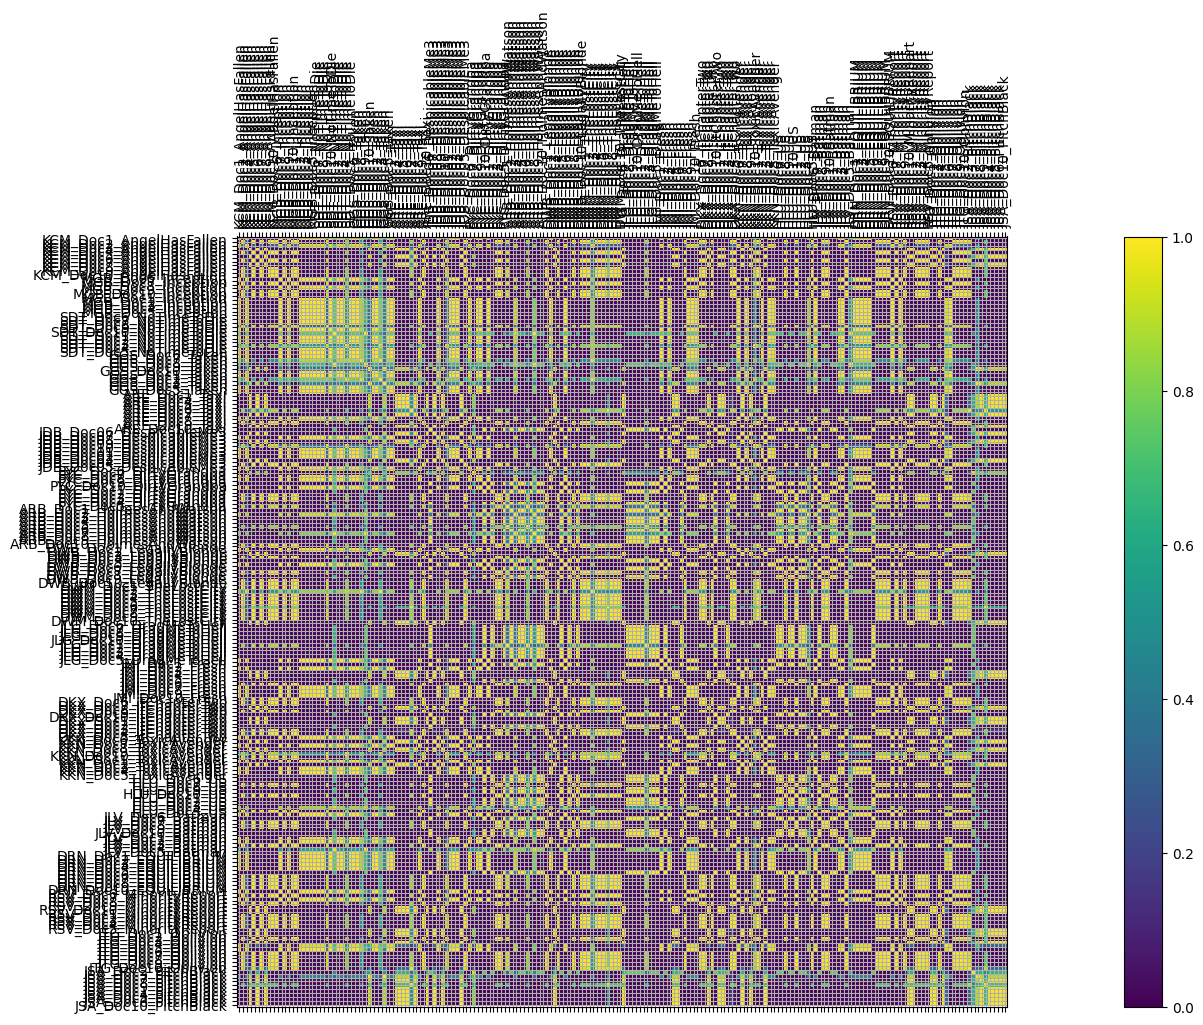

In [23]:
# BARRYC EXPERIMENTAL#1
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [24]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}

print(coherence)

[(0, '0.005*"movie" + 0.003*"things" + 0.002*"scene" + 0.002*"first" + 0.002*"might" + 0.002*"character" + 0.002*"chapter" + 0.002*"alison" + 0.002*"pennywise" + 0.002*"would"'), (1, '0.006*"movie" + 0.003*"action" + 0.003*"people" + 0.003*"preston" + 0.003*"world" + 0.003*"loretta" + 0.003*"equilibrium" + 0.003*"years" + 0.003*"first" + 0.003*"story"'), (2, '0.012*"movie" + 0.005*"toxic" + 0.004*"movies" + 0.003*"would" + 0.003*"action" + 0.003*"character" + 0.003*"avenger" + 0.003*"films" + 0.003*"people" + 0.003*"great"'), (3, '0.007*"movie" + 0.004*"would" + 0.004*"blonde" + 0.004*"witherspoon" + 0.003*"first" + 0.003*"scene" + 0.003*"equilibrium" + 0.003*"scenes" + 0.003*"harvard" + 0.003*"going"'), (4, '0.008*"movie" + 0.005*"horror" + 0.004*"story" + 0.003*"first" + 0.003*"would" + 0.003*"never" + 0.003*"action" + 0.003*"steve" + 0.003*"fresh" + 0.002*"scene"'), (5, '0.007*"batman" + 0.006*"holmes" + 0.004*"movie" + 0.004*"would" + 0.004*"watson" + 0.004*"joker" + 0.003*"action"

[(0, '0.007*"movie" + 0.003*"first" + 0.003*"would" + 0.003*"batman" + 0.002*"toxic" + 0.002*"character" + 0.002*"never" + 0.002*"characters" + 0.002*"things" + 0.002*"action"'), (1, '0.008*"movie" + 0.003*"would" + 0.003*"action" + 0.003*"movies" + 0.003*"first" + 0.003*"story" + 0.002*"something" + 0.002*"people" + 0.002*"world" + 0.002*"films"')]


[(0, '0.004*"cruise" + 0.004*"movie" + 0.003*"fallen" + 0.002*"planet" + 0.002*"banning" + 0.002*"bryan" + 0.002*"child" + 0.002*"scenes" + 0.002*"character" + 0.002*"space"'), (1, '0.006*"movie" + 0.004*"action" + 0.003*"makes" + 0.003*"years" + 0.003*"first" + 0.003*"world" + 0.003*"films" + 0.003*"little" + 0.003*"story" + 0.002*"preston"'), (2, '0.009*"movie" + 0.005*"toxic" + 0.004*"films" + 0.004*"action" + 0.003*"movies" + 0.003*"character" + 0.003*"world" + 0.003*"great" + 0.003*"people" + 0.003*"avenger"'), (3, '0.004*"bryan" + 0.004*"blonde" + 0.004*"movie" + 0.004*"scenes" + 0.003*"witherspoon" + 0.003*"would" + 0.003*"first" + 0.003*"enough" + 0.003*"legally" + 0.003*"horror"'), (4, '0.005*"anderton" + 0.005*"story" + 0.004*"movie" + 0.003*"would" + 0.003*"never" + 0.003*"black" + 0.003*"pitch" + 0.003*"scenes" + 0.003*"films" + 0.002*"action"'), (5, '0.015*"batman" + 0.008*"joker" + 0.006*"gotham" + 0.005*"bruce" + 0.005*"keaton" + 0.005*"wayne" + 0.004*"nicholson" + 0.004

&nbsp;

# **6. Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest**


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [25]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [26]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=20)

cluster_title {0: ['KKN_Doc6_ToxicAvenger', 'KKN_Doc7_ToxicAvenger', 'KKN_Doc8_ToxicAvenger', 'KKN_Doc9_ToxicAvenger', 'KKN_Doc10_ToxicAvenger', 'KKN_Doc1_ToxicAvenger', 'KKN_Doc2_ToxicAvenger', 'KKN_Doc3_ToxicAvenger', 'KKN_Doc4_ToxicAvenger', 'KKN_Doc5_ToxicAvenger'], 1: ['PYC_Doc6_DirtyGrandpa', 'PYC_Doc7_DirtyGrandpa', 'PYC_Doc8_DirtyGrandpa', 'PYC_Doc9_DirtyGrandpa', 'PYC_Doc10_DirtyGrandpa', 'PYC_Doc1_DirtyGrandpa', 'PYC_Doc2_DirtyGrandpa', 'PYC_Doc3_DirtyGrandpa', 'PYC_Doc4_DirtyGrandpa', 'PYC_Doc5_DirtyGrandpa'], 2: ['DRN_Doc1_EQUILIBRIUM', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc6_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'DRN_Doc8_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'DRN_Doc10_EQUILIBRIUM'], 3: ['GGS_Doc6_Taken', 'GGS_Doc7_Taken', 'GGS_Doc8_Taken', 'GGS_Doc9_Taken', 'GGS_Doc10_Taken', 'GGS_Doc1_Taken', 'GGS_Doc2_Taken', 'GGS_Doc3_Taken', 'GGS_Doc4_Taken', 'GGS_Doc5_Taken'], 4: ['DKX_Doc6_ItChapterTwo', 'DKX_Doc7_It

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [27]:
cluster_title[9]

['JSA_Doc2_PitchBlack',
 'JSA_Doc3_PitchBlack',
 'JSA_Doc7_PitchBlack',
 'JSA_Doc8_PitchBlack',
 'JSA_Doc9_PitchBlack',
 'JSA_Doc1_PitchBlack',
 'JSA_Doc4_PitchBlack',
 'JSA_Doc5_PitchBlack',
 'JSA_Doc6_PitchBlack',
 'JSA_Doc10_PitchBlack']

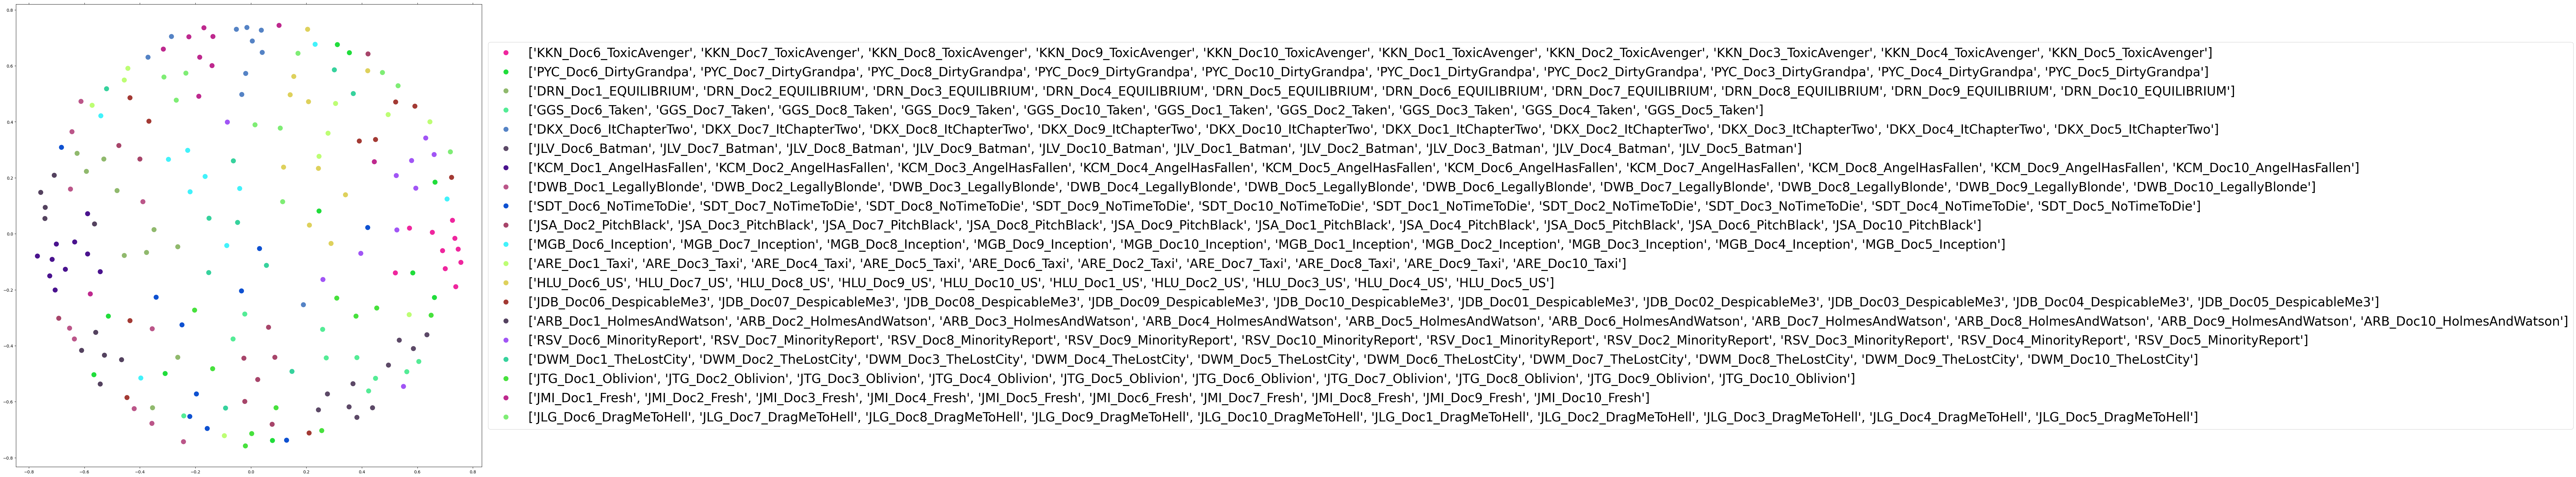

In [28]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [29]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
90     0
91     0
92     0
93     0
94     0
      ..
160    1
161    1
162    1
163    1
164    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br>
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [30]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.45

### Logistic Regression Model

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [31]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.55

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br>
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [32]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.5

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [33]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.6

# Part 1
Clustering Experiments:

In [34]:
# redefine the functions to take strings as input
def tokenize_document(text: str) -> List[str]:
    tokens = nltk.word_tokenize(text)
    return tokens

from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')

def lemmatize_text(text: str) -> str:
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return lemmatized_tokens

from nltk.stem import WordNetLemmatizer

from nltk.stem import WordNetLemmatizer

def lemmatize_word(word):
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
text = data['Text']


#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].to_list()

In [36]:
data['tokenized_text'] = data['processed_text'].apply(lambda x: tokenize_documents(x))

data['tokenized_text']

Doc_ID
90     [[target], [heavily], [outnumbered], [outgunne...
91     [[sleepy], [dopey], [action], [bonanza], [ange...
92     [[angel], [fallen], [marks], [third], [gerard]...
93     [[improving], [blandness], [banning], [gerard]...
94     [[review], [contain], [spoilers], [angel], [fa...
                             ...                        
160    [[batman], [promise], [delivered], [reeves], [...
161    [[batman], [begins], [unlike], [superhero], [f...
162    [[knight], [reeves], [batman], [different], [a...
163    [[throughout], [evolution], [batman], [charact...
164    [[reeves], [batman], [meticulously], [crafted]...
Name: tokenized_text, Length: 200, dtype: object

In [37]:
# edit defs
def tokenize_document(document: Document) -> TokenizedDocument:
     tokens = nltk.word_tokenize(document.text)
     return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
     return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
      output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
      result.append(TokenizedDocument(document.doc_id, output_tokens))
      return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
     result = []
     stemmer = PorterStemmer()
     for document in documents:
         output_tokens = [stemmer.stem(w) for w in document.tokens]
         result.append(TokenizedDocument(document.doc_id, output_tokens))

     return result

from nltk.stem import PorterStemmer

def stem_dataframe(dataframe, column_name):
    result = []
    stemmer = PorterStemmer()

    for tokens in dataframe[column_name]:
        stemmed_tokens = [stemmer.stem(w) for token_list in tokens for w in token_list]
        result.append(stemmed_tokens)

    return result

stemmed_tokens = stem_dataframe(data, 'tokenized_text')

In [38]:
stemmed_tokens

[['target',
  'heavili',
  'outnumb',
  'outgun',
  'ban',
  'gerard',
  'butler',
  'strive',
  'multilevel',
  'bulletriddl',
  'structur',
  'squadron',
  'soldier',
  'descend',
  'posit',
  'thank',
  'skill',
  'perfectli',
  'capabl',
  'overcom',
  'incred',
  'least',
  'overwrought',
  'edit',
  'audienc',
  'assum',
  'open',
  'sequenc',
  'alon',
  'camerawork',
  'shaki',
  'follow',
  'imposs',
  'exactli',
  'go',
  'washington',
  'ban',
  'await',
  'offer',
  'becom',
  'director',
  'secret',
  'servic',
  'presid',
  'allan',
  'trumbul',
  'morgan',
  'freeman',
  'despit',
  'year',
  'work',
  'protect',
  'presid',
  'sort',
  'mayhem',
  'certain',
  'readi',
  'behind',
  'career',
  'abus',
  'pill',
  'migrain',
  'dizzi',
  'insomnia',
  'make',
  'decis',
  'though',
  'piper',
  'perabo',
  'infant',
  'daughter',
  'would',
  'probabl',
  'appreci',
  'intens',
  'promot',
  'meanwhil',
  'longtim',
  'friend',
  'jen',
  'danni',
  'huston',
  'privat'

In [39]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
help(StandardScaler)

Help on class StandardScaler in module sklearn.preprocessing._data:

class StandardScaler(sklearn.base.OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  StandardScaler(*, copy=True, with_mean=True, with_std=True)
 |  
 |  Standardize features by removing the mean and scaling to unit variance.
 |  
 |  The standard score of a sample `x` is calculated as:
 |  
 |      z = (x - u) / s
 |  
 |  where `u` is the mean of the training samples or zero if `with_mean=False`,
 |  and `s` is the standard deviation of the training samples or one if
 |  `with_std=False`.
 |  
 |  Centering and scaling happen independently on each feature by computing
 |  the relevant statistics on the samples in the training set. Mean and
 |  standard deviation are then stored to be used on later data using
 |  :meth:`transform`.
 |  
 |  Standardization of a dataset is a common requirement for many
 |  machine learning estimators: they might behave badly if the
 |  individual feat

In [40]:
tfidf_matrix

aaron  abandon  abandoned  abandoning  abandonment  \
KCM_Doc1_AngelHasFallen    0.0      0.0   0.000000         0.0          0.0   
KCM_Doc2_AngelHasFallen    0.0      0.0   0.000000         0.0          0.0   
KCM_Doc3_AngelHasFallen    0.0      0.0   0.049318         0.0          0.0   
KCM_Doc4_AngelHasFallen    0.0      0.0   0.000000         0.0          0.0   
KCM_Doc5_AngelHasFallen    0.0      0.0   0.000000         0.0          0.0   
...                        ...      ...        ...         ...          ...   
JSA_Doc1_PitchBlack        0.0      0.0   0.000000         0.0          0.0   
JSA_Doc4_PitchBlack        0.0      0.0   0.000000         0.0          0.0   
JSA_Doc5_PitchBlack        0.0      0.0   0.056292         0.0          0.0   
JSA_Doc6_PitchBlack        0.0      0.0   0.047702         0.0          0.0   
JSA_Doc10_PitchBlack       0.0      0.0   0.000000         0.0          0.0   

                         abducted  abduction  abductor  abductors  abducts  \
KCM_Doc1_AngelHasFallen       0.0        0.0       0.0        0.0      0.0   
KCM_Doc2_AngelHasFallen       0.0        0.0       0.0        0.0      0.0   
KCM_Doc3_AngelHasFallen       0.0        0.0       0.0        0.0      0.0   
KCM_Doc4_AngelHasFallen       0.0        0.0       0.0        0.0      0.0   
KCM_Doc5_AngelHasFallen       0.0        0.0       0.0        0.0      0.0   
...                           ...        ...       ...        ...      ...   
JSA_Doc1_PitchBlack           0.0        0.0       0.0        0.0      0.0   
JSA_Doc4_PitchBlack           0.0        0.0       0.0        0.0      0.0   
JSA_Doc5_PitchBlack           0.0        0.0       0.0        0.0      0.0   
JSA_Doc6_PitchBlack           0.0        0.0       0.0        0.0      0.0   
JSA_Doc10_PitchBlack          0.0        0.0       0.0        0.0      0.0   

                         ...  òloud  òmarry  ònothing  òreno  òsaturday  \
KCM_Doc1_AngelHasFallen  ...    0.0     0.0       0.0    0.0        0.0   
KCM_Doc2_AngelHasFallen  ...    0.0     0.0       0.0    0.0        0.0   
KCM_Doc3_AngelHasFallen  ...    0.0     0.0       0.0    0.0        0.0   
KCM_Doc4_AngelHasFallen  ...    0.0     0.0       0.0    0.0        0.0   
KCM_Doc5_AngelHasFallen  ...    0.0     0.0       0.0    0.0        0.0   
...                      ...    ...     ...       ...    ...        ...   
JSA_Doc1_PitchBlack      ...    0.0     0.0       0.0    0.0        0.0   
JSA_Doc4_PitchBlack      ...    0.0     0.0       0.0    0.0        0.0   
JSA_Doc5_PitchBlack      ...    0.0     0.0       0.0    0.0        0.0   
JSA_Doc6_PitchBlack      ...    0.0     0.0       0.0    0.0        0.0   
JSA_Doc10_PitchBlack     ...    0.0     0.0       0.0    0.0        0.0   

                         òspecialó  òtaxió  òthose  òvertigoó  òyouõre  
KCM_Doc1_AngelHasFallen        0.0     0.0     0.0        0.0      0.0  
KCM_Doc2_AngelHasFallen        0.0     0.0     0.0        0.0      0.0  
KCM_Doc3_AngelHasFallen        0.0     0.0     0.0        0.0      0.0  
KCM_Doc4_AngelHasFallen        0.0     0.0     0.0        0.0      0.0  
KCM_Doc5_AngelHasFallen        0.0     0.0     0.0        0.0      0.0  
...                            ...     ...     ...        ...      ...  
JSA_Doc1_PitchBlack            0.0     0.0     0.0        0.0      0.0  
JSA_Doc4_PitchBlack            0.0     0.0     0.0        0.0      0.0  
JSA_Doc5_PitchBlack            0.0     0.0     0.0        0.0      0.0  
JSA_Doc6_PitchBlack            0.0     0.0     0.0        0.0      0.0  
JSA_Doc10_PitchBlack           0.0     0.0     0.0        0.0      0.0  

[200 rows x 14906 columns]

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf_vectorizer = TfidfVectorizer()

k = 5  # i geussed what k was
kmeans = KMeans(n_clusters=k)
pred_1 = kmeans.fit_predict(tfidf_matrix)


In [42]:
kmeans

KMeans(n_clusters=5)

In [43]:
cluster_labels = kmeans.labels_

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Print cluster assignments and centers
print("Cluster Assignments:", cluster_labels)
print("Cluster Centers:", cluster_centers)

Cluster Assignments: [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 1 4 3 4 3 3 3 1 1 1 3 1 3 3 1
 1 1 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 1 1 1 3 1 3 3 3 3 1 1 3 3 3 1 3 2 2 2 2
 2 2 2 2 2 2 4 3 3 4 4 3 1 1 3 3 4 4 4 4 4 4 4 4 4 4 3 1 1 1 1 1 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 3 3 3 3 3 3 1 1 1 1 1 1 1 1
 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 1 3 3
 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1]
Cluster Centers: [[ 4.33680869e-19 -1.08420217e-19  1.32675548e-02 ...  0.00000000e+00
  -5.42101086e-20 -5.42101086e-20]
 [ 6.00612503e-04 -1.62630326e-18  2.85278075e-03 ...  0.00000000e+00
   1.08420217e-19  1.08420217e-19]
 [ 4.33680869e-19  8.06294488e-03  2.16840434e-19 ...  0.00000000e+00
  -5.42101086e-20 -5.42101086e-20]
 [ 2.16840434e-18  1.06779174e-03  5.67010594e-04 ...  6.03717645e-04
   5.38327519e-04  5.38327519e-04]
 [ 2.37748930e-02  0.00000000e+00  8.67361738e-19 ...  0.00000000e+00
  -1.08420217e-19 -1.08420217e-19]]


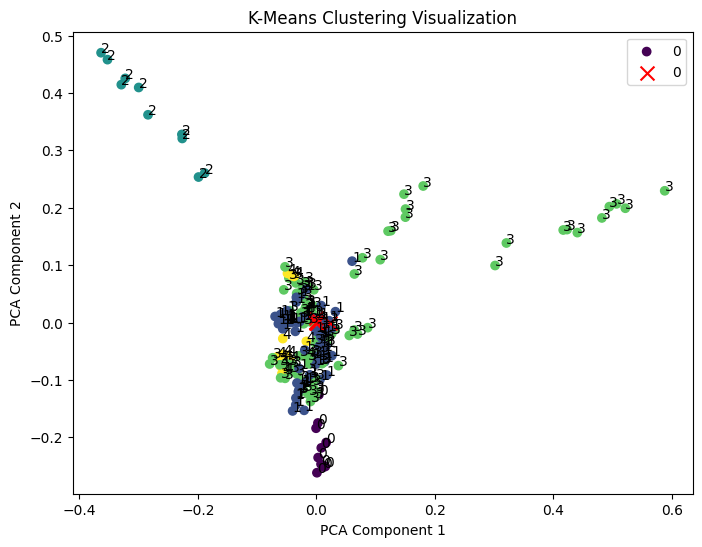

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
perplexity = 30  # Define your perplexity value
def plot_tsne(data, labels, perplexity, experiment_name, figsize=(40, 40)):
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)

    for i in range(len(x)):
        new_value = new_values[i]
        x_val = new_value[0]
        y_val = new_value[1]

        plt.scatter(x_val, y_val)
        plt.annotate(labels[i],
                     xy=(x_val, y_val),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # You can return labels here if needed
    return labels

# pca to reduce dimensionality (replace with your data)
pca = PCA(n_components=2)
data_2d = pca.fit_transform(tfidf_matrix)

# Create a scatter plot for the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=cluster_labels, cmap='viridis')

# Add cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=100, label='Cluster Centers')

# Annotate data points with labels
labels = [str(label) for label in cluster_labels]
for i, label in enumerate(labels):
    plt.annotate(label, (data_2d[i, 0], data_2d[i, 1]))

# Add labels to the legend (if you have specific labels for the clusters)
plt.legend(labels, loc='best')

# Set axis labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering Visualization')

# Show the plot
plt.show()

cluster = (corpus_df.loc[:, ['DSI_Title', 'Genre of Movie', 'Text']]
                                    .assign(cluster_label=cluster_labels))

In [45]:
cluster.query(f"cluster_label == 1")

DSI_Title Genre of Movie  \
Doc_ID                                           
57      BKG_Doc8_No_Time_to_Die         Action   
56      BKG_Doc7_No_Time_to_Die         Action   
70               DHB_Doc1_Taken         Action   
71               DHB_Doc2_Taken         Action   
73               DHB_Doc4_Taken         Action   
...                         ...            ...   
160         MEM_Doc1_The_Batman         Sci-Fi   
161         MEM_Doc2_The_Batman         Sci-Fi   
162         MEM_Doc3_The_Batman         Sci-Fi   
163         MEM_Doc4_The_Batman         Sci-Fi   
164         MEM_Doc5_The_Batman         Sci-Fi   

                                                     Text  cluster_label  
Doc_ID                                                                    
57      Nothing can truly kill James Bond , but the CO...              1  
56      As Robert Graves wrote when he was ridding him...              1  
70      To save you the time in either watching this f...              1  
71      I 've never written a review before , but this...              1  
73      Maybe I expected more because it 's an issue I...              1  
...                                                   ...            ...  
160     The Batman is a promise delivered by Matt Reev...              1  
161     The Batman begins unlike most superhero films ...              1  
162     The Dark Knight is back in Matt Reeves ' `` Th...              1  
163     Throughout the evolution of the Batman charact...              1  
164     Matt Reeves ' The Batman is a meticulously cra...              1  

[72 rows x 4 columns]

In [46]:
cluster.query(f"cluster_label == 2")

DSI_Title Genre of Movie  \
Doc_ID                                               
10       HBI_Doc1_Holmes_and_Watson         Comedy   
11       HBI_Doc2_Holmes_and_Watson         Comedy   
15       HBI_Doc6_Holmes_and_Watson         Comedy   
16       HBI_Doc7_Holmes_and_Watson         Comedy   
17       HBI_Doc8_Holmes_and_Watson         Comedy   
12       HBI_Doc3_Holmes_and_Watson         Comedy   
13       HBI_Doc4_Holmes_and_Watson         Comedy   
14       HBI_Doc5_Holmes_and_Watson         Comedy   
18       HBI_Doc9_Holmes_and_Watson         Comedy   
19      HBI_Doc10_Holmes_and_Watson         Comedy   

                                                     Text  cluster_label  
Doc_ID                                                                    
10      Out of some morbid curiosity , and perhaps a s...              2  
11      Dear eight-pound , six-ounce , newborn baby Je...              2  
15      There 's a moment during the stunningly abysma...              2  
16      The start of Holmes & Watson is both cynical a...              2  
17      The script for what eventually became the simp...              2  
12      The comedy so execrable that audiences evacuat...              2  
13      Maybe it 's just the holiday spirit , but I ca...              2  
14      One of the year 's most critically shellacked ...              2  
18      Hooray , it 's the annual return of the `` Mar...              2  
19      Holmes & Watson is probably exactly what I 'd ...              2

In [47]:
cluster.query(f"cluster_label == 3")

DSI_Title Genre of Movie  \
Doc_ID                                         
85         SHR_Doc6_Inception         Action   
86         SHR_Doc7_Inception         Action   
87         SHR_Doc8_Inception         Action   
88         SHR_Doc9_Inception         Action   
89        SHR_Doc10_Inception         Action   
...                       ...            ...   
195      MKW_Doc6_Pitch_Black         Sci-Fi   
196      MKW_Doc7_Pitch_Black         Sci-Fi   
198      MKW_Doc9_Pitch_Black         Sci-Fi   
199     MKW_Doc10_Pitch_Black         Sci-Fi   
191      MKW_Doc2_Pitch_Black         Sci-Fi   

                                                     Text  cluster_label  
Doc_ID                                                                    
85      Contrary to the opinions of the deluded army o...              3  
86      I have to say to make such an impressive trail...              3  
87      I had the misfortune of choosing to squander b...              3  
88      Inception is certainly ambitious . And once ag...              3  
89      Christopher Nolan has done some great work . H...              3  
...                                                   ...            ...  
195     If you ever wondered what it might feel like t...              3  
196     Pitch Black is action science-fiction that bar...              3  
198     When a spaceship crash-lands on a planet of th...              3  
199     `` Pitch Black '' is the first movie I 've see...              3  
191     Packed with razzle-dazzle special effects and ...              3  

[91 rows x 4 columns]

In [48]:
cluster.query(f"cluster_label == 4")

DSI_Title Genre of Movie  \
Doc_ID                                           
58      BKG_Doc9_No_Time_to_Die         Action   
52      BKG_Doc3_No_Time_to_Die         Action   
36              KDB_Doc7_Barbie         Comedy   
37              KDB_Doc8_Barbie         Comedy   
45            MDO_Doc6_LostCity         Comedy   
48            MDO_Doc9_LostCity         Comedy   
49           MDO_Doc10_LostCity         Comedy   
1           XOY_Doc2_Mean_Girls         Comedy   
2           XOY_Doc3_Mean_Girls         Comedy   
3           XOY_Doc4_Mean_Girls         Comedy   
4           XOY_Doc5_Mean_Girls         Comedy   
8           XOY_Doc9_Mean_Girls         Comedy   
0           XOY_Doc1_Mean_Girls         Comedy   
5           XOY_Doc6_Mean_Girls         Comedy   
6           XOY_Doc7_Mean_Girls         Comedy   
7           XOY_Doc8_Mean_Girls         Comedy   
9          XOY_Doc10_Mean_Girls         Comedy   

                                                     Text  cluster_label  
Doc_ID                                                                    
58      Not long into No Time to Die , James Bond ( Da...              4  
52      The caretakers of the Intellectual Property kn...              4  
36      It 's a shame because I love Little Women and ...              4  
37      I did not understand this movie at all . It ha...              4  
45      Prolific and reclusive romance novelist Lorett...              4  
48      Am not sure what director brothers Adam Nee , ...              4  
49      We are curious which writer or director forced...              4  
1       Although Mean Girls is likely to be frequently...              4  
2       She is immediately befriended by two of North ...              4  
3       Mean Girls '' is somewhat of a phenomenon in t...              4  
4       The tagline for this movie - Watch Your Back -...              4  
8       When 16-year-old Cady ( Lindsay Lohan ) first ...              4  
0       `` In a wasteland of dumb movies about teenage...              4  
5       Mean Girls looks and feels like a 2000s comedy...              4  
6       Teenage Cady Heron ( Lindsay Lohan ) was educa...              4  
7       Fans who found teen star Lindsay Lohan 's last...              4  
9       'Gretchen , stop trying to make 'fetch ' happe...              4

In [49]:
cluster.query(f"cluster_label == 0")

DSI_Title Genre of Movie  \
Doc_ID                                              
90       LKP_Doc1_Angel_has_fallen         Action   
91       LKP_Doc2_Angel_has_fallen         Action   
92       LKP_Doc3_Angel_has_fallen         Action   
93       LKP_Doc4_Angel_has_fallen         Action   
94       LKP_Doc5_Angel_has_fallen         Action   
95       LKP_Doc6_Angel_has_fallen         Action   
96       LKP_Doc7_Angel_has_fallen         Action   
97       LKP_Doc8_Angel_has_fallen         Action   
98       LKP_Doc9_Angel_has_fallen         Action   
99      LKP_Doc10_Angel_has_fallen         Action   

                                                     Text  cluster_label  
Doc_ID                                                                    
90      Target is on the move . '' Heavily outnumbered...              0  
91      The sleepy , dopey action bonanza `` Angel Has...              0  
92      `` Angel Has Fallen '' marks the third time th...              0  
93      Improving through blandness . So Mike Banning ...              0  
94      This review may contain spoilers . Angel Has F...              0  
95      As I left the theater the other night , I bega...              0  
96      Angel Has Fallen may not be appreciably better...              0  
97      Gerard Butler continues to burnish his brand o...              0  
98      American movie presidents can only make us wis...              0  
99      The `` Has Fallen '' series , `` Olympus , '' ...              0

The red 'x' markers in the plot represent the cluster centers. These are the centroids of the clusters. The positions of the cluster centers are computed based on the data points within each cluster. There are a couple movies that dont match the word clusters. These outliers rely heavily on...

In [50]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


flattened_tokens = [word for sublist in stemmed_tokens for word in sublist]
one_hot_encoded = One_Hot(flattened_tokens)

In [51]:
one_hot_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import pandas as pd

documents = [TaggedDocument(words=words, tags=[i]) for i, words in enumerate(stemmed_tokens)]

# create Doc2Vec
model_doc2vec = Doc2Vec(vector_size=200, min_count=1, workers=4)
model_doc2vec.build_vocab(documents)
model_doc2vec.train(documents, total_examples=model_doc2vec.corpus_count, epochs=10)

document_vectors = [model_doc2vec.infer_vector(document.words) for document in documents]
features_doc2vec = pd.DataFrame(document_vectors)

features_doc2vec.shape


(200, 200)

In [53]:
transformed_features_doc2vec = standard_scaler.fit_transform(features_doc2vec)

In [54]:
# set up another k means
model_kmeans = KMeans(n_clusters=4,
                      random_state=20130810)
model_kmeans.fit(transformed_features_doc2vec)

KMeans(n_clusters=4, random_state=20130810)

In [55]:
labels_kmeans = model_kmeans.labels_

In [56]:
from sklearn.metrics import silhouette_score

silhouette_score(transformed_features_doc2vec, labels_kmeans)

0.4483243

In [57]:
for k in [4, 5, 6, 7, 8, 9]:

    model_kmeans = KMeans(n_clusters=k,
                          random_state=20130810)
    model_kmeans.fit(transformed_features_doc2vec)
    sil_score = silhouette_score(transformed_features_doc2vec, model_kmeans.labels_)
    print(f"k = {k}, silhouette score = {sil_score}")

k = 4, silhouette score = 0.4483242928981781
k = 5, silhouette score = 0.4326278269290924
k = 6, silhouette score = 0.4063970148563385
k = 7, silhouette score = 0.40535813570022583
k = 8, silhouette score = 0.3749984800815582
k = 9, silhouette score = 0.34358179569244385


In [58]:
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(transformed_features_doc2vec)
labels_kmeans = model_kmeans.labels_

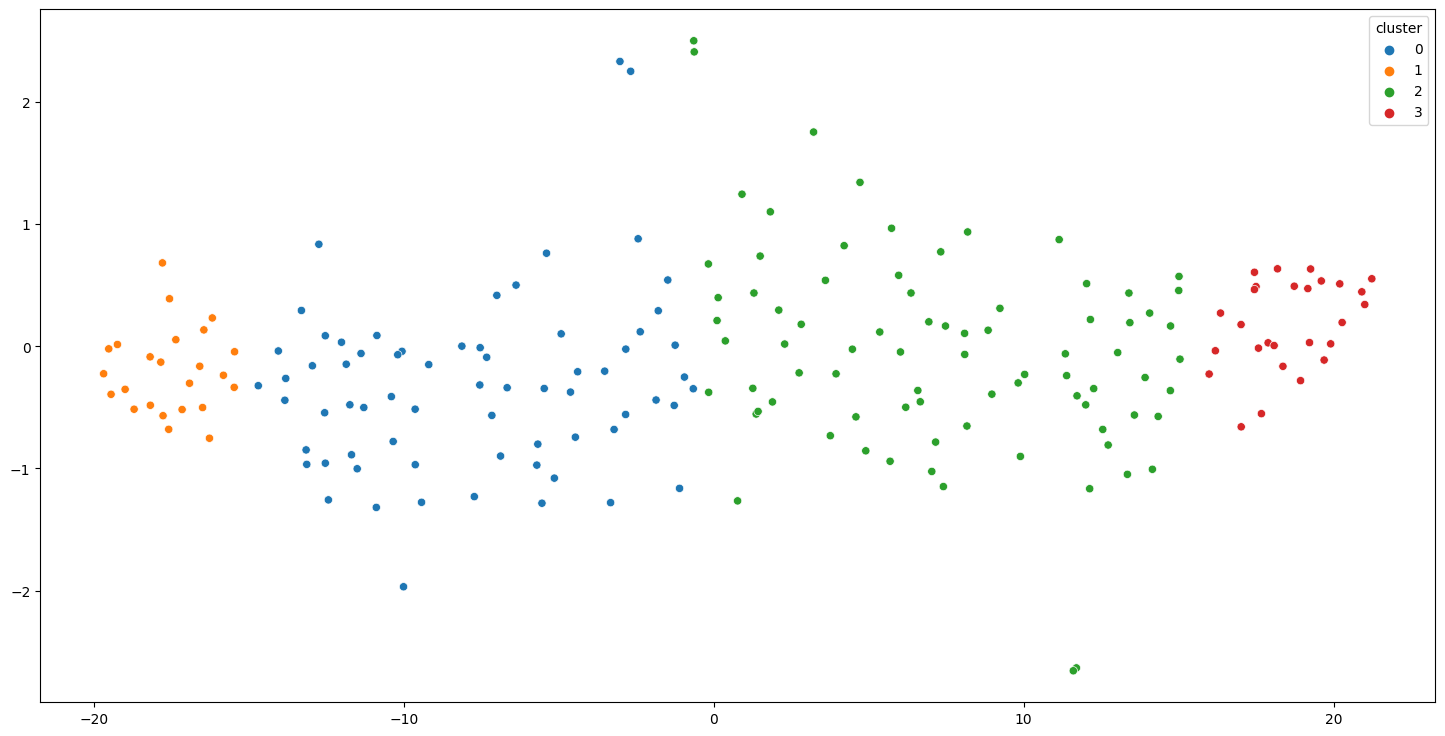

In [59]:
model_tsne = TSNE(n_components=2)
transformed_values = model_tsne.fit_transform(transformed_features_doc2vec)
X, Y = [], []

for value in transformed_values:
    X.append(value[0])
    Y.append(value[1])
plt.figure(figsize=(18, 9))

labels_kmeans_str = pd.Series(labels_kmeans.astype(str), name='cluster')

sns.scatterplot(x=X,
                y=Y,
                hue=labels_kmeans_str,
                hue_order=['0', '1', '2', '3']);


In [60]:
documents_by_cluster = (corpus_df.loc[:, ['DSI_Title', 'Genre of Movie', 'Text']]
                                    .assign(cluster_label=labels_kmeans))

In [61]:
from collections import Counter

In [62]:
documents_by_cluster.query(f"cluster_label == 1")

DSI_Title Genre of Movie  \
Doc_ID                                               
93        LKP_Doc4_Angel_has_fallen         Action   
94        LKP_Doc5_Angel_has_fallen         Action   
86               SHR_Doc7_Inception         Action   
81               SHR_Doc2_Inception         Action   
84               SHR_Doc5_Inception         Action   
74                   DHB_Doc5_Taken         Action   
61                    VGI_Doc2_Taxi         Action   
35                  KDB_Doc6_Barbie         Comedy   
36                  KDB_Doc7_Barbie         Comedy   
37                  KDB_Doc8_Barbie         Comedy   
39                 KDB_Doc10_Barbie         Comedy   
33                  KDB_Doc4_Barbie         Comedy   
25           JCT_Doc6_Dirty_Grandpa         Comedy   
16       HBI_Doc7_Holmes_and_Watson         Comedy   
19      HBI_Doc10_Holmes_and_Watson         Comedy   
132        JLL_Doc3_Drag_Me_To_Hell         Horror   
113             HAK_Doc4_The_Others         Horror   
177        DSM_Doc8_Minority_Report         Sci-Fi   
178        DSM_Doc9_Minority_Report         Sci-Fi   
189              AVR_Doc10_Oblivion         Sci-Fi   
192            MKW_Doc3_Pitch_Black         Sci-Fi   
193            MKW_Doc4_Pitch_Black         Sci-Fi   
194            MKW_Doc5_Pitch_Black         Sci-Fi   
160             MEM_Doc1_The_Batman         Sci-Fi   

                                                     Text  cluster_label  
Doc_ID                                                                    
93      Improving through blandness . So Mike Banning ...              1  
94      This review may contain spoilers . Angel Has F...              1  
86      I have to say to make such an impressive trail...              1  
81      This has to be Christopher Nolan 's best film ...              1  
84      I want this to be a very accurate and very con...              1  
74      Alright , I watched the movie about a few week...              1  
61      This is what movies should be like . It is an ...              1  
35      Just watched this today and honestly I do n't ...              1  
36      It 's a shame because I love Little Women and ...              1  
37      I did not understand this movie at all . It ha...              1  
39      Such an incredible steaming pile of liberal ga...              1  
33      it 's amazing . of course , i would be biased ...              1  
25      I really do n't have a problem with any genre ...              1  
16      The start of Holmes & Watson is both cynical a...              1  
19      Holmes & Watson is probably exactly what I 'd ...              1  
132     Drag Me To Hell is one wild ride of a movie . ...              1  
113     Once upon a time on the Isle of Jersey in the ...              1  
177     I recently sat down to watch this movie again ...              1  
178     Prior to the release of this movie there were ...              1  
189     What 's the difference between a derivative kn...              1  
192     Pitch Black is one of my favorite science fict...              1  
193     `` Pitch Black '' is a pretty solid blend of a...              1  
194     About Monsters ... Pitch Black was n't about t...              1  
160     The Batman is a promise delivered by Matt Reev...              1

In [63]:
docgroup2 = documents_by_cluster.query("cluster_label == 2")
docgroup2_u = docgroup2['DSI_Title'].unique()
docgroup2_u = pd.Series(docgroup2_u)
docgroup2_u.to_csv('docgroup2_u.csv', index=False)


In [64]:
documents_by_cluster.query(f"cluster_label == 3")
docgroup3 = documents_by_cluster.query("cluster_label == 3")
docgroup3_u = docgroup3['DSI_Title'].unique()
docgroup3_u = pd.Series(docgroup3_u)
docgroup3_u.to_csv('docgroup3_u.csv', index=False)


In [65]:
documents_by_cluster.query(f"cluster_label == 0")
docgroup0 = documents_by_cluster.query("cluster_label == 0")
docgroup0_u = docgroup0['DSI_Title'].unique()
docgroup0_u = pd.Series(docgroup0_u)
docgroup0_u.to_csv('docgroup0_u.csv', index=False)

In [66]:
# Quality of features extracted from text (e.g., tf-idf and doc2vec) can be acertained by the quality of the clusters generated using these features. These clusters also highlight potential patterns within the corpus.

# Part 2

Sentiment Analysis Experiments:

In [67]:
! pip install nltk
! pip install textblob
! pip install -U spacy
import pandas as pd
from textblob import TextBlob
from nltk.tokenize.toktok import ToktokTokenizer
import re
tokenizer = ToktokTokenizer()
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [68]:
train = data

In [69]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)

In [70]:
label_0=data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
label_1=data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)

In [71]:
train = train[['Doc_ID', 'processed_text', 'tokenized_text']]

In [72]:
train.head(80)

Doc_ID                                     processed_text  \
Doc_ID                                                              
90          90  [target, heavily, outnumbered, outgunned, bann...   
91          91  [sleepy, dopey, action, bonanza, angel, fallen...   
92          92  [angel, fallen, marks, third, gerard, butler, ...   
93          93  [improving, blandness, banning, gerard, butler...   
94          94  [review, contain, spoilers, angel, fallen, thi...   
...        ...                                                ...   
12          12  [comedy, execrable, audiences, evacuated, ende...   
13          13  [maybe, holiday, spirit, particularly, frustra...   
14          14  [critically, shellacked, movies, forced, watch...   
18          18  [hooray, annual, return, strong, holmes, watso...   
19          19  [holmes, watson, probably, exactly, expect, fe...   

                                           tokenized_text  
Doc_ID                                                     
90      [[target], [heavily], [outnumbered], [outgunne...  
91      [[sleepy], [dopey], [action], [bonanza], [ange...  
92      [[angel], [fallen], [marks], [third], [gerard]...  
93      [[improving], [blandness], [banning], [gerard]...  
94      [[review], [contain], [spoilers], [angel], [fa...  
...                                                   ...  
12      [[comedy], [execrable], [audiences], [evacuate...  
13      [[maybe], [holiday], [spirit], [particularly],...  
14      [[critically], [shellacked], [movies], [forced...  
18      [[hooray], [annual], [return], [strong], [holm...  
19      [[holmes], [watson], [probably], [exactly], [e...  

[80 rows x 3 columns]

In [73]:
# figure how to also include processed_text variable
#convert words to strings
train['processed_text'] = train['processed_text'].apply(lambda word_list: ' '.join(word_list))

# Now, you can apply sentiment analysis using TextBlob
train['sentiment'] = train['processed_text'].apply(lambda text: TextBlob(text).sentiment)


In [74]:
sentiment_series = train['sentiment'].tolist()

In [75]:
columns = ['polarity', 'subjectivity']
df1 = pd.DataFrame(sentiment_series, columns=columns, index=train.index)

In [76]:
df1

polarity  subjectivity
Doc_ID                        
90     -0.013210      0.428072
91     -0.004067      0.470238
92     -0.062812      0.443311
93      0.163176      0.470586
94      0.047348      0.506818
...          ...           ...
160     0.129741      0.506034
161    -0.005952      0.568878
162     0.099242      0.382197
163     0.216468      0.624603
164     0.164461      0.461029

[200 rows x 2 columns]

In [77]:
result = pd.concat([train,df1],axis=1)

In [78]:
result.drop(['sentiment'],axis=1,inplace=True)

In [79]:
result.loc[result['polarity']>=0.3, 'Sentiment'] = "Positive"
result.loc[result['polarity']<0.3, 'Sentiment'] = "Negative"

In [80]:
result.to_csv('Polarity_results.csv')

In [81]:
result['Sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [82]:
result


Doc_ID                                     processed_text  \
Doc_ID                                                              
90          90  target heavily outnumbered outgunned banning g...   
91          91  sleepy dopey action bonanza angel fallen disap...   
92          92  angel fallen marks third gerard butler secret ...   
93          93  improving blandness banning gerard butler weig...   
94          94  review contain spoilers angel fallen third mov...   
...        ...                                                ...   
160        160  batman promise delivered reeves planet directo...   
161        161  batman begins unlike superhero films thrust po...   
162        162  knight reeves batman different approach atmosp...   
163        163  throughout evolution batman character incarnat...   
164        164  reeves batman meticulously crafted takes chara...   

                                           tokenized_text  polarity  \
Doc_ID                                                                
90      [[target], [heavily], [outnumbered], [outgunne... -0.013210   
91      [[sleepy], [dopey], [action], [bonanza], [ange... -0.004067   
92      [[angel], [fallen], [marks], [third], [gerard]... -0.062812   
93      [[improving], [blandness], [banning], [gerard]...  0.163176   
94      [[review], [contain], [spoilers], [angel], [fa...  0.047348   
...                                                   ...       ...   
160     [[batman], [promise], [delivered], [reeves], [...  0.129741   
161     [[batman], [begins], [unlike], [superhero], [f... -0.005952   
162     [[knight], [reeves], [batman], [different], [a...  0.099242   
163     [[throughout], [evolution], [batman], [charact...  0.216468   
164     [[reeves], [batman], [meticulously], [crafted]...  0.164461   

        subjectivity Sentiment  
Doc_ID                          
90          0.428072  Negative  
91          0.470238  Negative  
92          0.443311  Negative  
93          0.470586  Negative  
94          0.506818  Negative  
...              ...       ...  
160         0.506034  Negative  
161         0.568878  Negative  
162         0.382197  Negative  
163         0.624603  Negative  
164         0.461029  Negative  

[200 rows x 6 columns]

In [83]:
result.to_csv('Polarity_result(2)')

# Part 3

Classification

In [84]:
movie_genre = data['Genre of Movie']

In [85]:
data['Genre of Movie'].value_counts()

Genre of Movie
Action    50
Comedy    50
Horror    50
Sci-Fi    50
Name: count, dtype: int64

In [86]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, movie_genre,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [87]:
y_test.value_counts()

Genre of Movie
Action    18
Horror    17
Comedy    16
Sci-Fi    15
Name: count, dtype: int64

In [88]:
model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

In [89]:
y_pred = model_svm.predict(X_test)
y_pred

array(['Action', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi'],
      dtype=object)

In [90]:
accuracy_score(y_test, y_pred)

0.24242424242424243

In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.33      0.39      0.36        18
      Comedy       0.00      0.00      0.00        16
      Horror       0.00      0.00      0.00        17
      Sci-Fi       0.20      0.60      0.30        15

    accuracy                           0.24        66
   macro avg       0.13      0.25      0.16        66
weighted avg       0.14      0.24      0.17        66



In [92]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000]:
    model_svm = SVC(C=C_value)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.22727272727272727
C: 0.1, Accuracy: 0.22727272727272727
C: 1, Accuracy: 0.24242424242424243
C: 10, Accuracy: 0.2878787878787879
C: 100, Accuracy: 0.2878787878787879
C: 1000, Accuracy: 0.36363636363636365
C: 10000, Accuracy: 0.8939393939393939


In [93]:
model_svm = SVC(C=1)
model_svm.fit(X_train, y_train)

SVC(C=1)

In [94]:
model_svm.predict(X_test)

array(['Action', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Action',
       'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Sci-Fi', 'Sci-Fi', 'Action', 'Sci-Fi', 'Sci-Fi',
       'Sci-Fi', 'Action', 'Action', 'Sci-Fi', 'Action', 'Sci-Fi'],
      dtype=object)


Conclusion
When text is an input to a supervised learning task (e.g., sentiment analysis or multi-class prediction) detailed examination of the classification metrics helps select the appropriate feature engineering process.

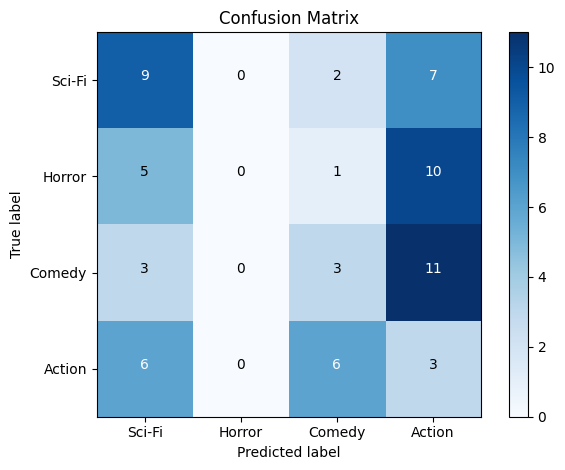

Accuracy: 0.22727272727272727
Precision: 0.1845196353436185
Recall: 0.21911764705882353
F1-score: 0.19408893114418402


In [95]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import itertools

# create a cm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cmSVM = confusion_matrix(y_test, y_pred)

class_labels = ['Sci-Fi', 'Horror', 'Comedy', 'Action']

plt.imshow(cmSVM, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

thresh = cmSVM.max() / 2.
for i, j in itertools.product(range(cmSVM.shape[0]), range(cmSVM.shape[1])):
    plt.text(j, i, format(cmSVM[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cmSVM[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


# Part 4

Topic Modeling Experiments:



In [96]:
NUM_TOPICS = 2

In [97]:
dictionary = corpora.Dictionary(processed_text)

In [98]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text]

In [99]:
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

In [100]:
lsamodel = LsiModel(doc_term_matrix,
                    num_topics=NUM_TOPICS,
                    id2word=dictionary,
                    power_iters=100)

In [101]:
lsamodel.print_topics(num_words=10)

[(0,
  '0.525*"movie" + 0.149*"would" + 0.147*"action" + 0.141*"story" + 0.135*"barbie" + 0.130*"characters" + 0.120*"first" + 0.119*"really" + 0.119*"world" + 0.116*"character"'),
 (1,
  '0.414*"holmes" + -0.404*"movie" + -0.361*"barbie" + 0.281*"watson" + 0.195*"ferrell" + 0.171*"reilly" + 0.163*"sherlock" + 0.134*"comedy" + 0.094*"brothers" + 0.088*"years"')]

In [102]:
topics = [2, 4, 6, 8]
coherence_values = {}

for t in topics:
    lsamodel = LsiModel(doc_term_matrix,
                        num_topics=t,
                        id2word=dictionary,
                        power_iters=100)

    coherence_model_lsa = CoherenceModel(model=lsamodel,
                                         dictionary=dictionary,
                                         texts=processed_text,
                                         coherence='c_v')

    coherence_lsa = coherence_model_lsa.get_coherence()

    coherence_values[str(t) + ' topics'] = coherence_lsa

In [103]:
print(coherence_values)

{'2 topics': 0.36482402363749483, '4 topics': 0.3580580276702909, '6 topics': 0.3527860519912546, '8 topics': 0.29793679324644845}


In [104]:
NUM_TOPICS = 4

In [105]:
matrix_doc = [dictionary.doc2bow(doc) for doc in processed_text]

In [106]:
ldamodel = LdaModel(matrix_doc,
                    num_topics=NUM_TOPICS,
                    id2word = dictionary,
                    alpha='auto',
                    eta='auto',
                    eval_every=1,
                    iterations=100,
                    passes=20,
                    random_state=20130810)

In [107]:
! pip install pyLDAvis

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_display = gensimvis.prepare(ldamodel, matrix_doc, dictionary, sort_topics=False)


pyLDAvis.display(lda_display)


In [108]:
!jupyter nbconvert --to html /A_2_Clustering_and_Classification.ipynb

[NbConvertApp] WARNING | pattern '/A_2_Clustering_and_Classification.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_

In [109]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [110]:
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# Assuming you have already created the LDA visualization as lda_display
# Create the LDA visualization using pyLDAvis.gensim.prepare

# Save the LDA visualization as a local HTML file
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

# Now, you can display the HTML file using an HTML iframe in your Jupyter Notebook
from IPython.display import IFrame

# Specify the path to the HTML file you saved
html_path = 'lda_visualization.html'

# Display the HTML file using an iframe
IFrame(html_path, width=800, height=600)
